In [1]:
import numpy as np
import matplotlib.pyplot as plt
from coffea import util
from coffea.processor import accumulate
import hist
import os
import re
import pandas as pd

In [2]:
f_sig = "/uscms_data/d3/sbrightt/iDM/iDMe_analysis/CMSSW_10_6_26/src/iDMeAnalysis/python_analysis/outputs/sig/signal_2018_aEM_SR_studies.coffea"
f_qcd = "/uscms_data/d3/sbrightt/iDM/iDMe_analysis/CMSSW_10_6_26/src/iDMeAnalysis/python_analysis/outputs/bkg/bkg_2018_QCD_TuneCP5_PSWeights_SR_studies.coffea"
sig = util.load(f_sig)[0]
qcd = util.load(f_qcd)[0]

In [3]:
sig_samples = list(sig['cutflow'].keys())
qcd_samples = list(qcd['cutflow'].keys())
def signalPoint(name):
    a = re.search('Mchi-(\d+p\d)_dMchi-(\d+p\d)_ctau-(\d+)',name)
    mchi = float(a.group(1).replace("p","."))
    dmchi = float(a.group(2).replace("p","."))
    ctau = float(a.group(3).replace("p","."))
    m1 = mchi - dmchi/2
    m2 = mchi + dmchi/2
    delta = dmchi/m1
    return {"mchi":mchi, "dmchi":dmchi, "ctau":ctau, "m1":m1, "m2":m2, "delta":delta, "name":name}
si = pd.DataFrame.from_dict({s:signalPoint(s) for s in sig_samples},orient='index')

def getCut(label,n=2):
    name = ""
    while label[0:n]!=label[n:2*n] and n<len(label):
        name=label[0:n+1]
        n+=1
    return name

cutNames = {cname:getCut(sig['cutDesc'][cname]) for cname in sig['cutDesc'].keys()}

In [4]:
cutNames

{'initial': 'No cuts',
 'cut0': 'Preselection',
 'cut1': 'Pass MET Filters',
 'cut2': 'HEM Veto',
 'cut3': 'MET Trigger (120 GeV)',
 'cut4': 'MET > 200 GeV',
 'cut5': '0 < nJets < 3 (pT > 30 GeV)',
 'cut6': 'No b-tagged jets',
 'cut7': 'Leading jet |eta| < 2.4',
 'cut8': 'Leading jet pT > 80 GeV',
 'cut9': 'dPhi(MET,leading jet) > 1.5',
 'cut10': 'dPhi(MET,all jets) > 0.75',
 'cut11': 'OSSF'}

# Cutflow plots

In [5]:
# background cutflows
cf_q = qcd['cutflow']
cfc_q = qcd['cutflow_cts']
tot_cfc_q = accumulate([cfc_q[k] for k in cfc_q.keys()])
cuts = tot_cfc_q.keys()
nev = tot_cfc_q['initial']
tot_cf_q = {c:tot_cfc_q[c]/nev for c in cuts}

In [6]:
cf_s = sig['cutflow']
ct_s = sig['cutflow_cts']
desc = sig['cutDesc']
cuts = list(cf_s[list(cf_s.keys())[0]].keys())
deltas = sorted(list(set(si.delta)))
ctaus = sorted(list(set(si.ctau)))

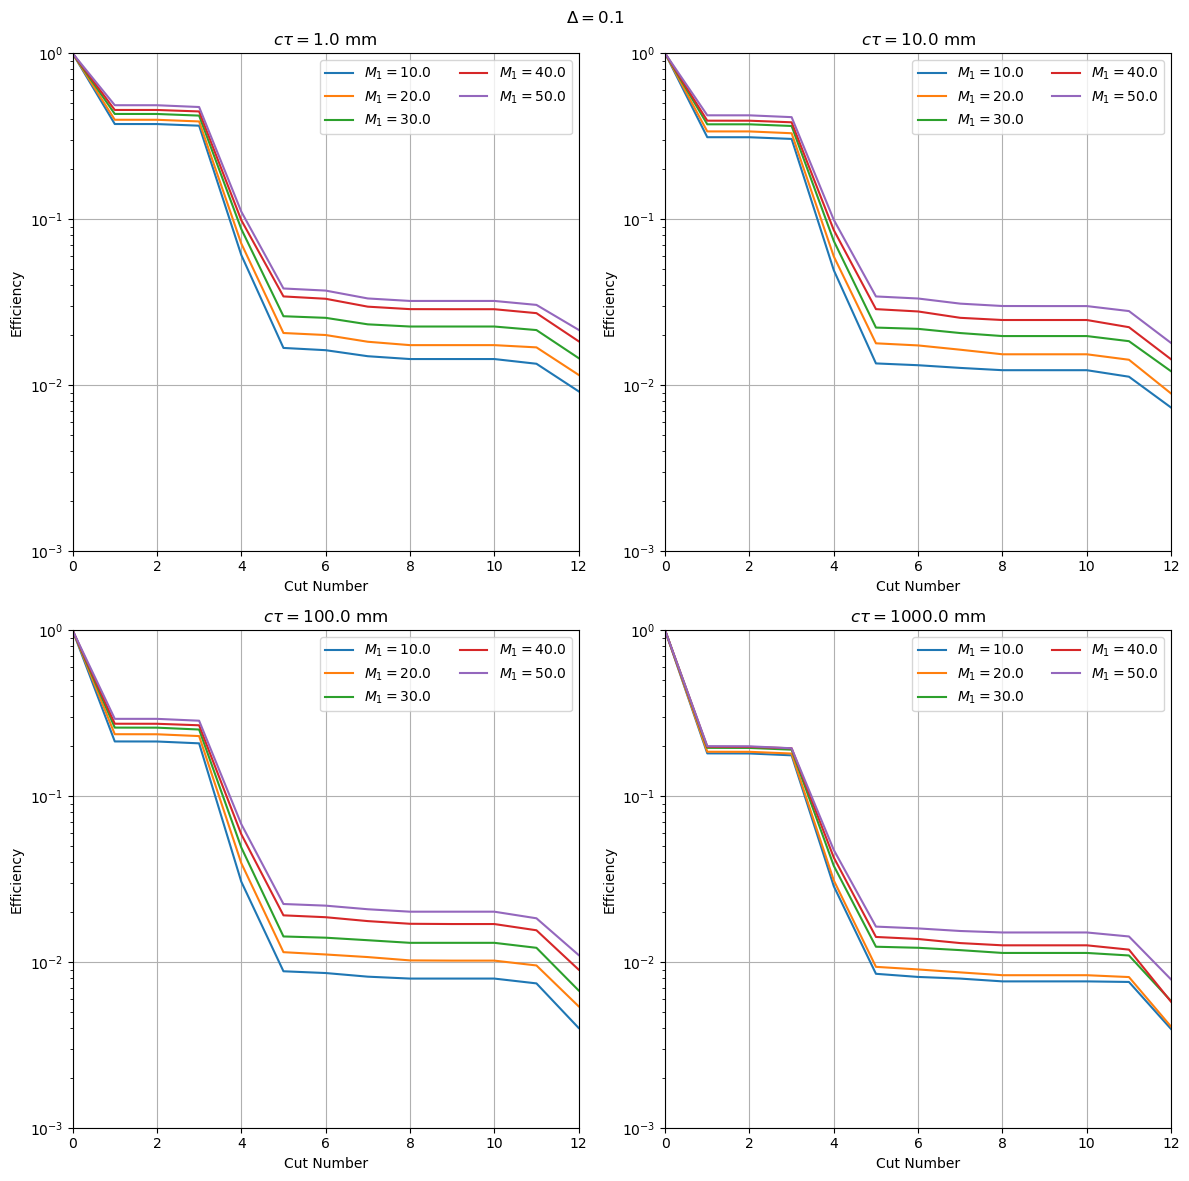

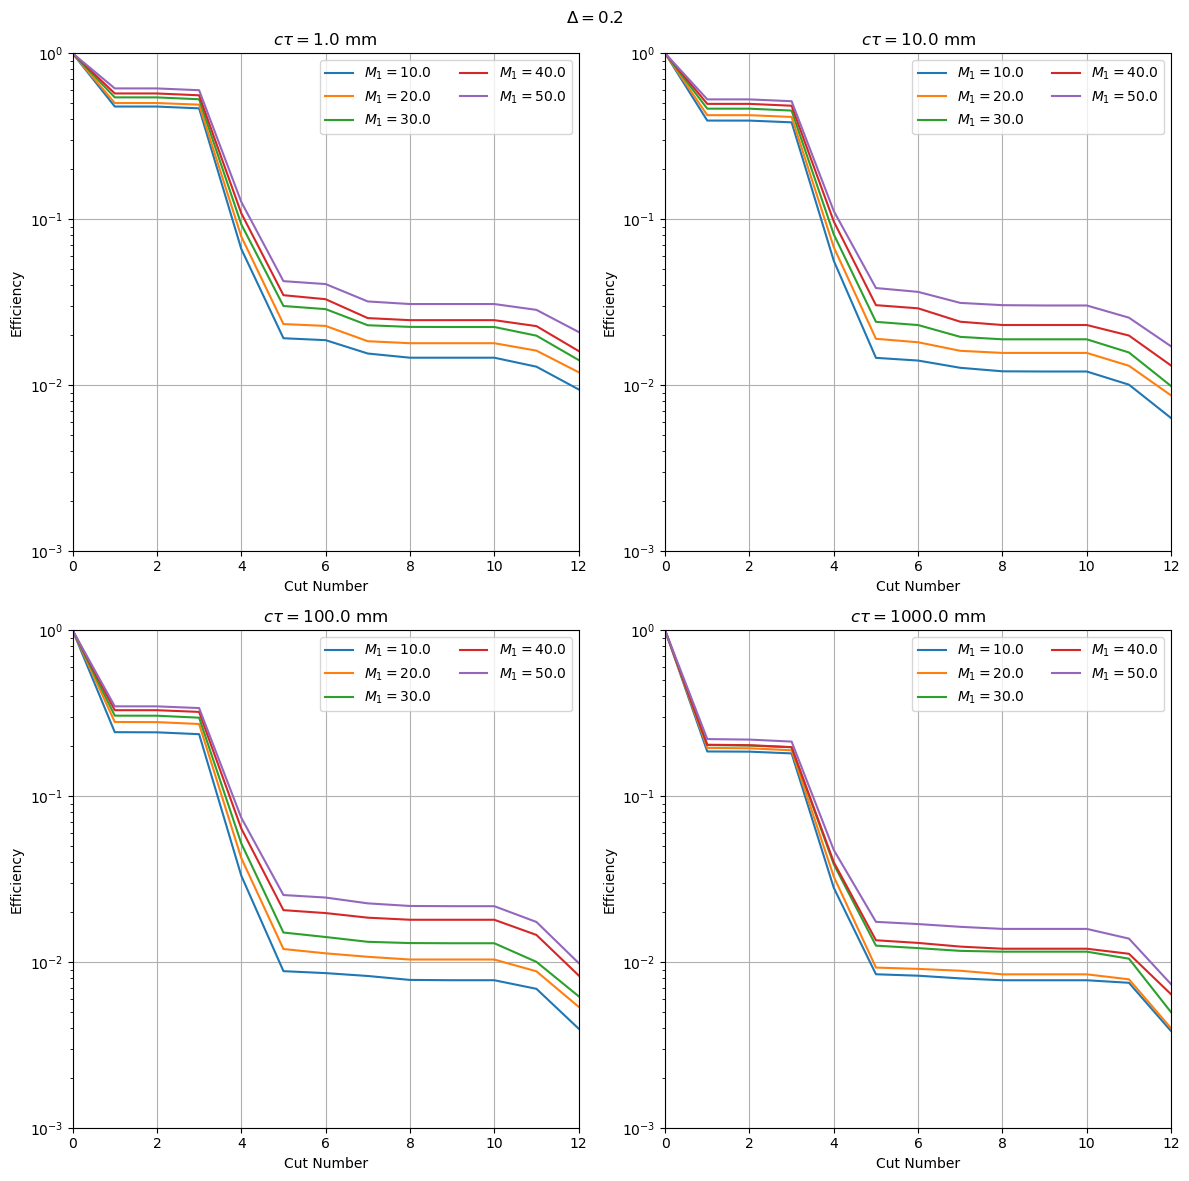

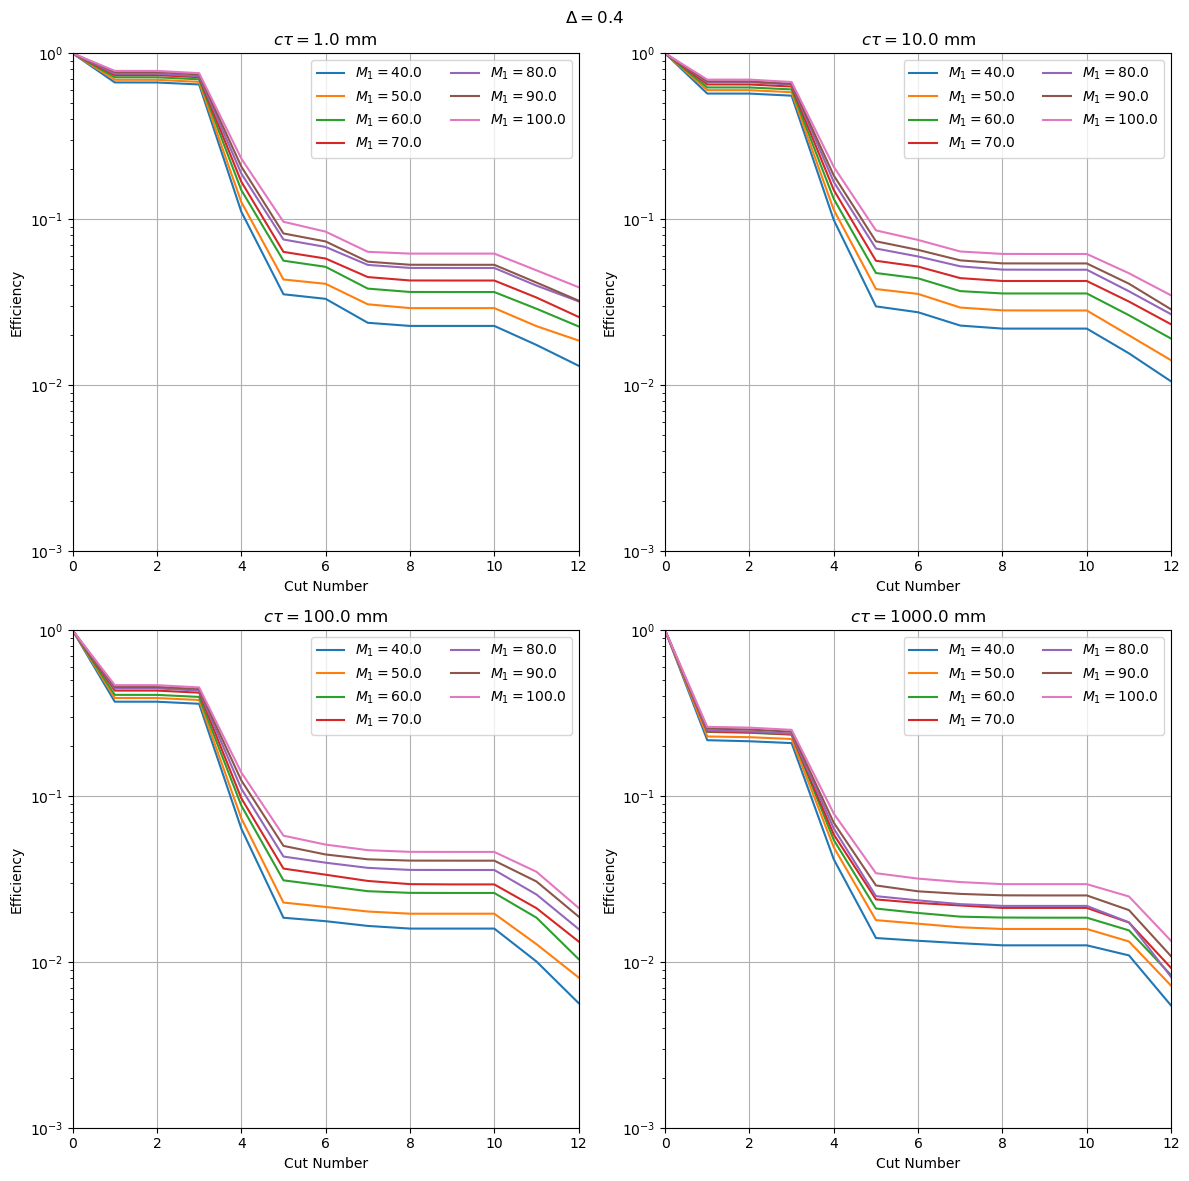

In [7]:
# signal efficiencies by delta/ctau
for delta in deltas:
    plt.figure(figsize=(12,12))
    m1s = sorted(list(set(si[si.delta==delta].m1)))
    for i,ct in enumerate(ctaus):
        plt.subplot(2,2,i+1)
        plt.title(r"$c\tau = {0}$ mm".format(ct))
        for m1 in m1s:
            pt = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
            effs = [cf_s[pt][cut] for cut in cuts]
            plt.plot(np.arange(len(cuts)),effs,label=r"$M_1 = {0}$".format(m1))
        plt.legend(loc='upper right',ncol=2)
        plt.ylim([0.001,1])
        plt.xlim([0,len(cuts)-1])
        plt.yscale('log')
        plt.ylabel("Efficiency")
        plt.xlabel("Cut Number")
        plt.grid()
    plt.suptitle(r"$\Delta = {0:.1f}$".format(delta))
    plt.tight_layout()
    plt.savefig(f"plots/cutflows/signal_effs_delta{delta:.1f}.pdf")
    #plt.close()

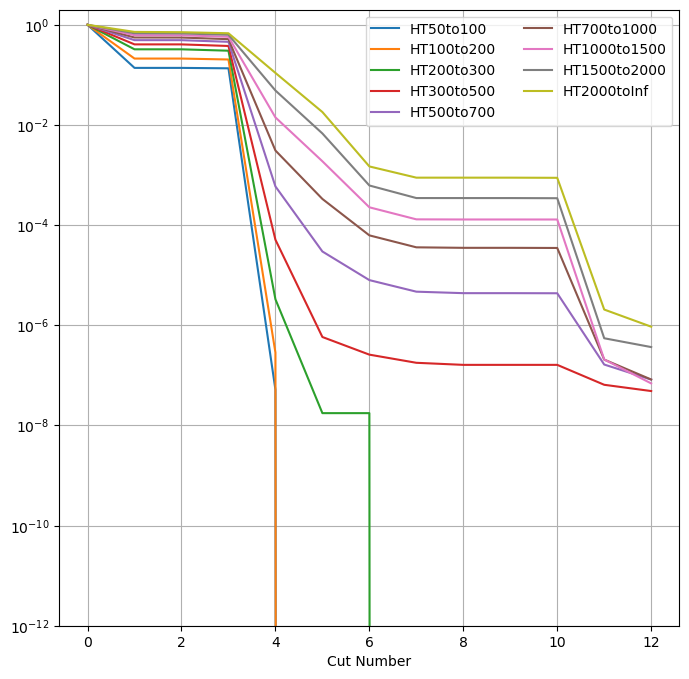

In [10]:
# bkg efficiencies
plt.figure(figsize=(8,8))
ht_bins = list(cf_q.keys())
ht_bins = sorted(ht_bins,key=lambda x: int(re.search("HT(\d+)",x).group(1)))
for bkg_pt in ht_bins:
    cf = cf_q[bkg_pt]
    effs = [cf[c] for c in cf.keys()]
    plt.plot(np.arange(len(effs)),effs,label=bkg_pt.split("_")[-1])
plt.ylim([1e-12,2])
plt.yscale('log')
plt.legend(loc='upper right',ncol=2)
plt.grid()
plt.xlabel("Cut Number")
plt.savefig("plots/cutflows/qcd_eff_byHTbin.pdf")
#plt.close()

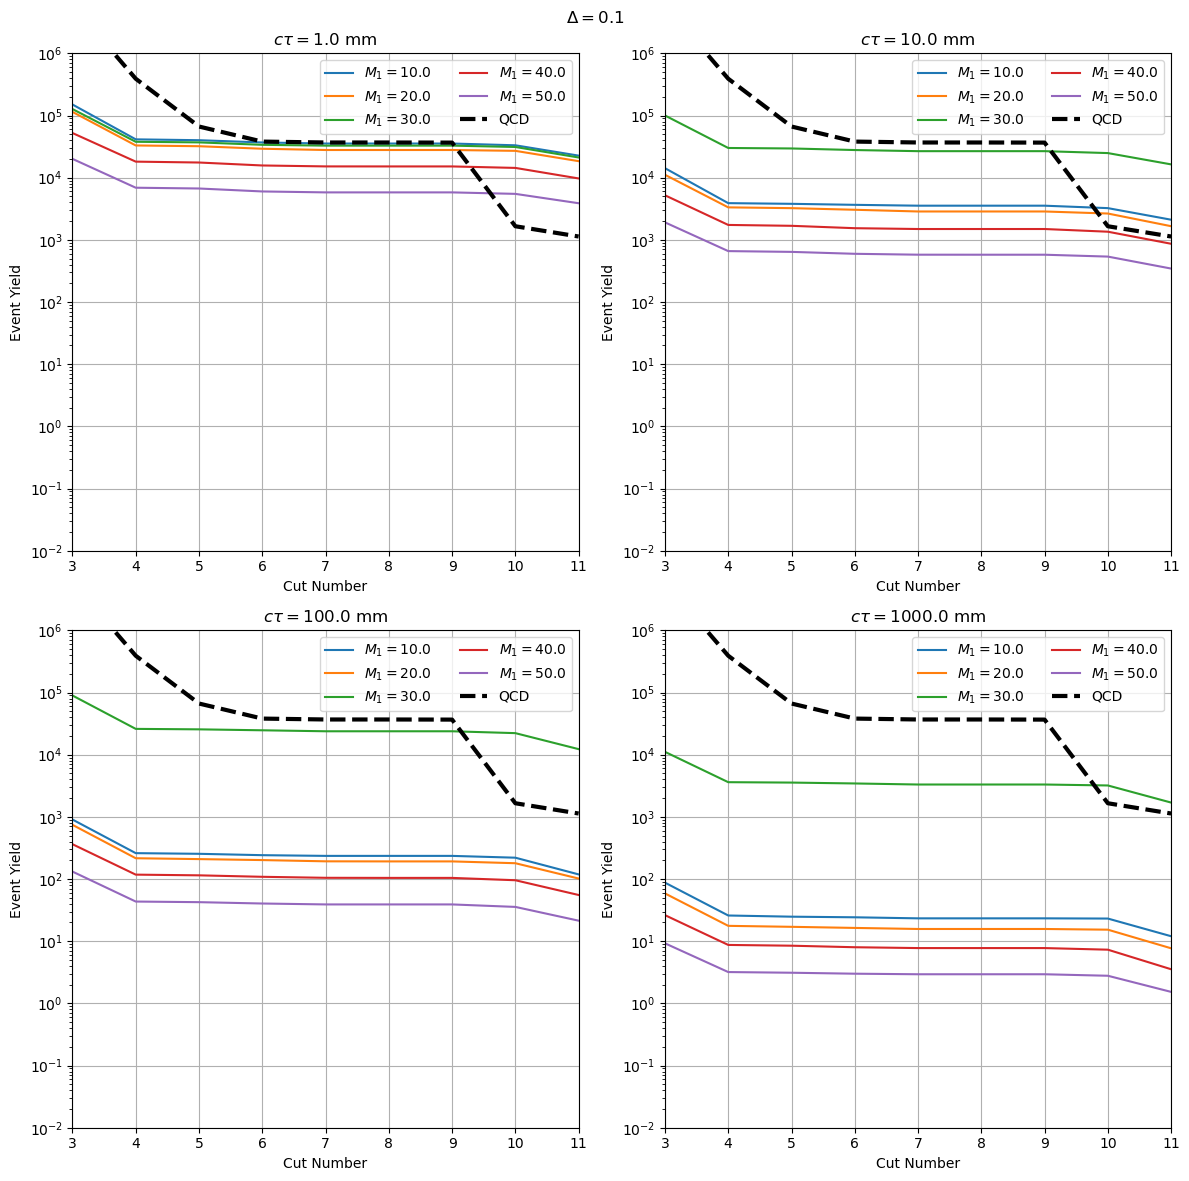

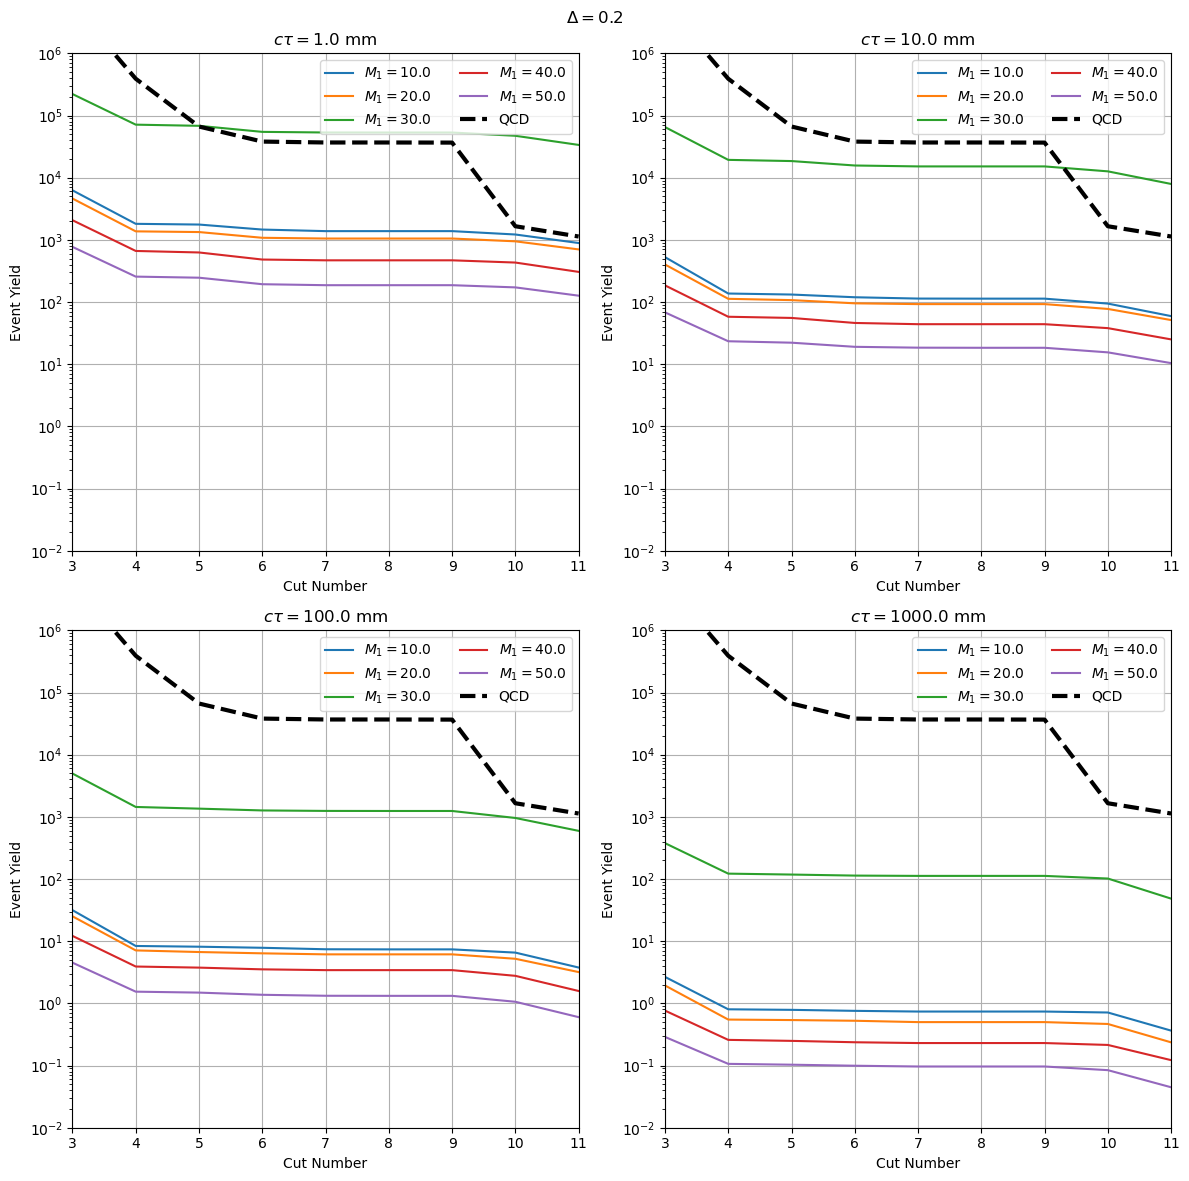

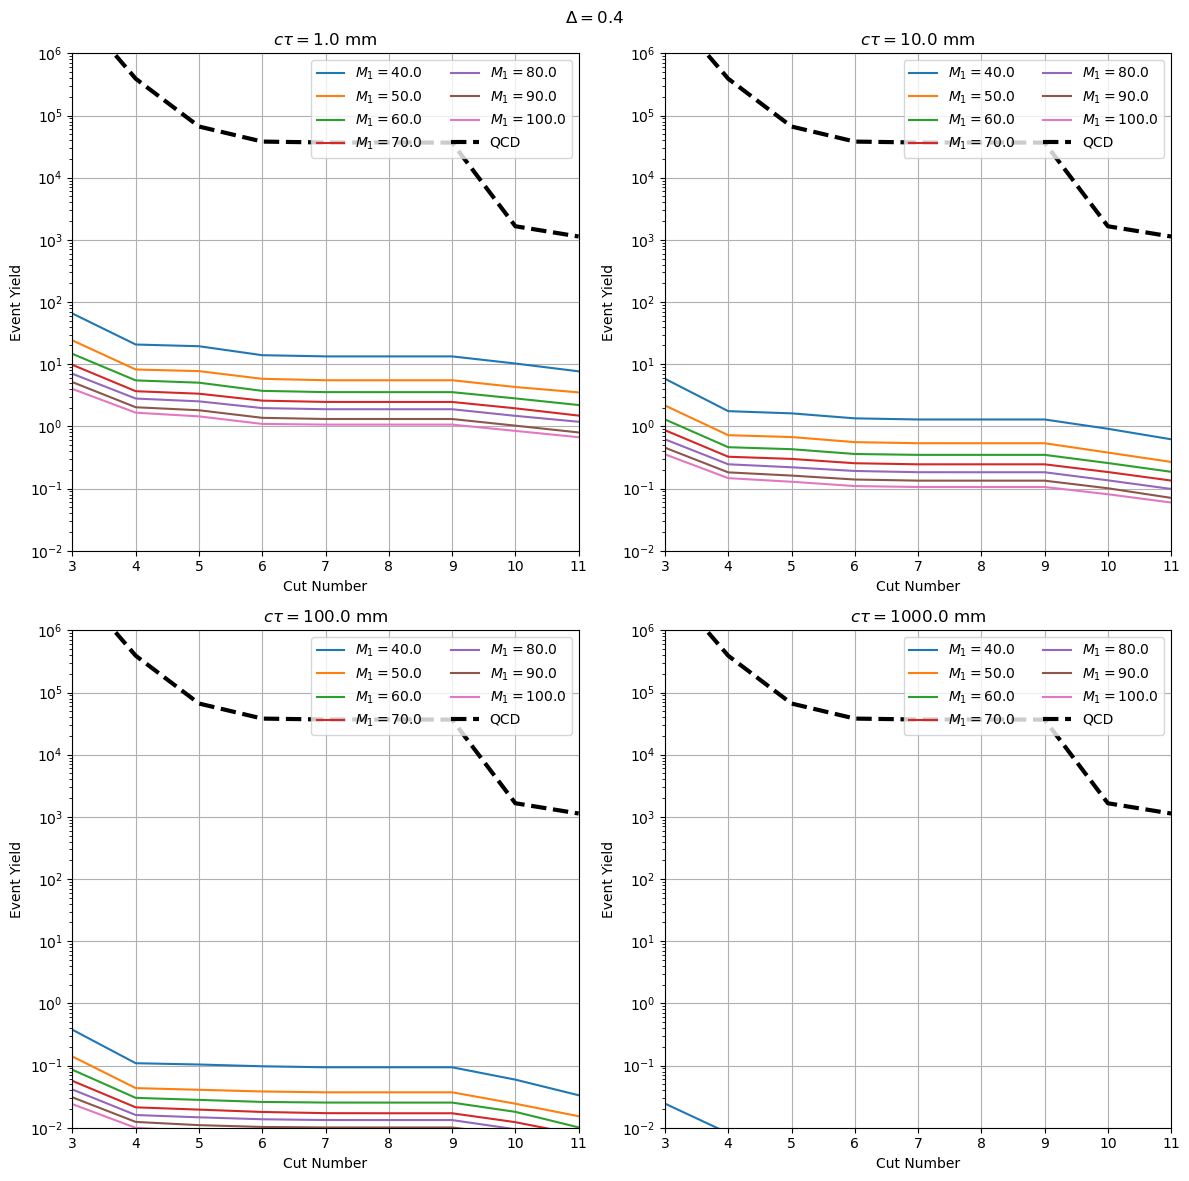

In [11]:
# sig vs qcd event yields, starting after MET trigger cut (cut3)
cut3above = [f"cut{n}" for n in np.arange(3,12)]
for delta in deltas:
    plt.figure(figsize=(12,12))
    m1s = sorted(list(set(si[si.delta==delta].m1)))
    for i,ct in enumerate(ctaus):
        plt.subplot(2,2,i+1)
        plt.title(r"$c\tau = {0}$ mm".format(ct))
        for m1 in m1s:
            pt = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
            effs = [ct_s[pt][cut] for cut in cut3above]
            plt.plot(np.arange(3,12),effs,label=r"$M_1 = {0}$".format(m1))
        plt.plot(np.arange(3,12),[tot_cfc_q[cut] for cut in cut3above],label="QCD",linestyle='--',linewidth=3,color='k')
        plt.legend(loc='upper right',ncol=2)
        plt.ylim([1e-2,1e6])
        plt.xlim([3,11])
        plt.yscale('log')
        plt.ylabel("Event Yield")
        plt.xlabel("Cut Number")
        plt.grid()
    plt.suptitle(r"$\Delta = {0:.1f}$".format(delta))
    plt.tight_layout()
    plt.savefig(f"plots/cutflows/signal_vs_bkg_counts_delta{delta:.1f}.pdf")
    #plt.close()

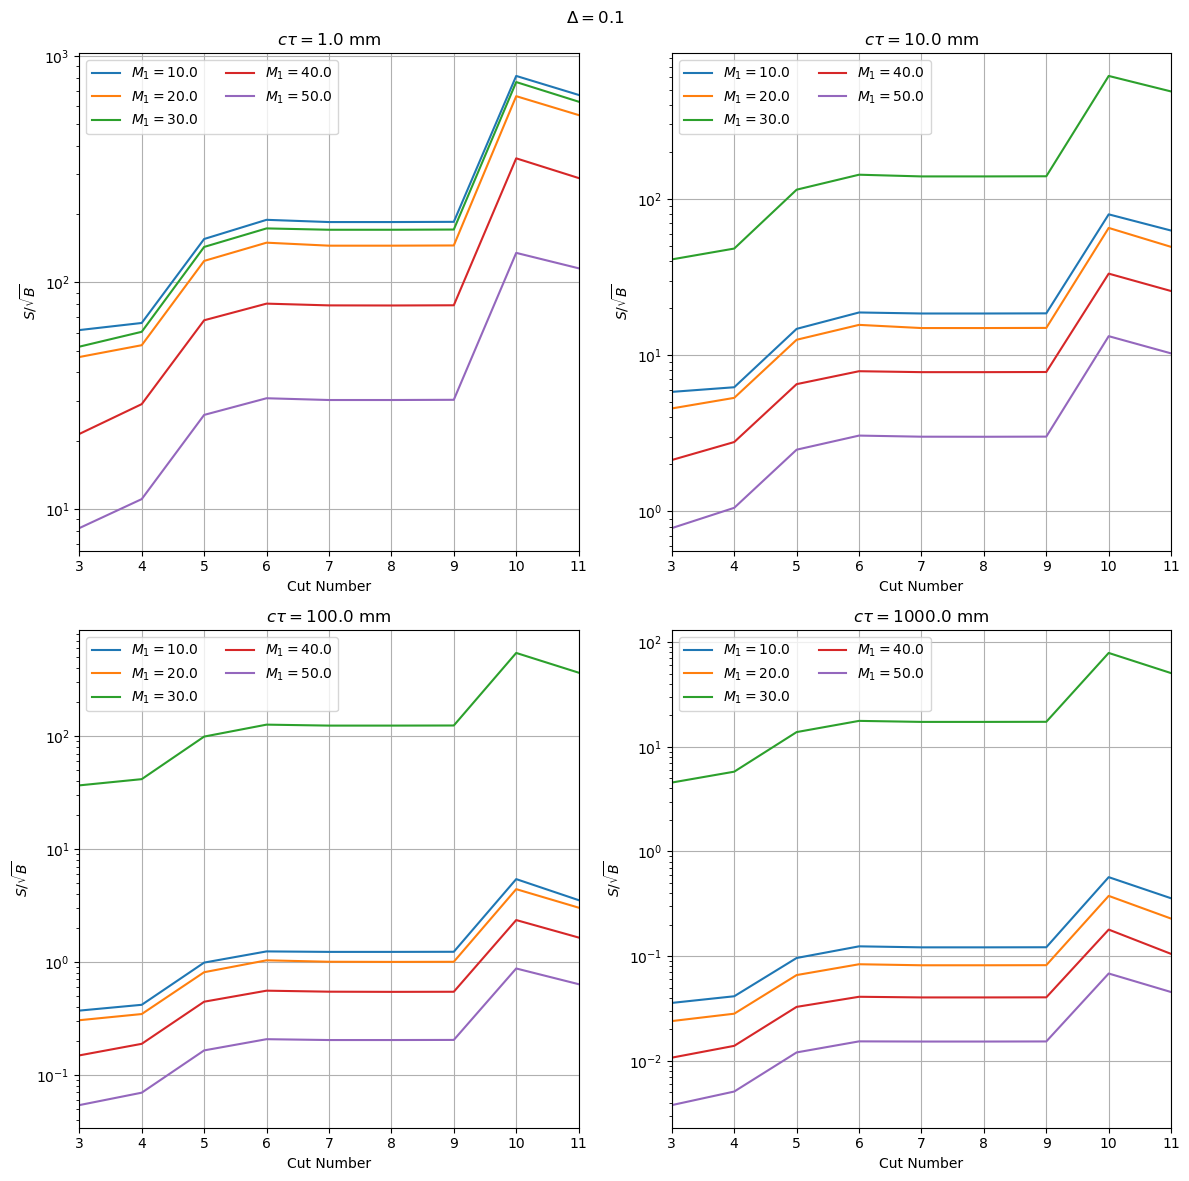

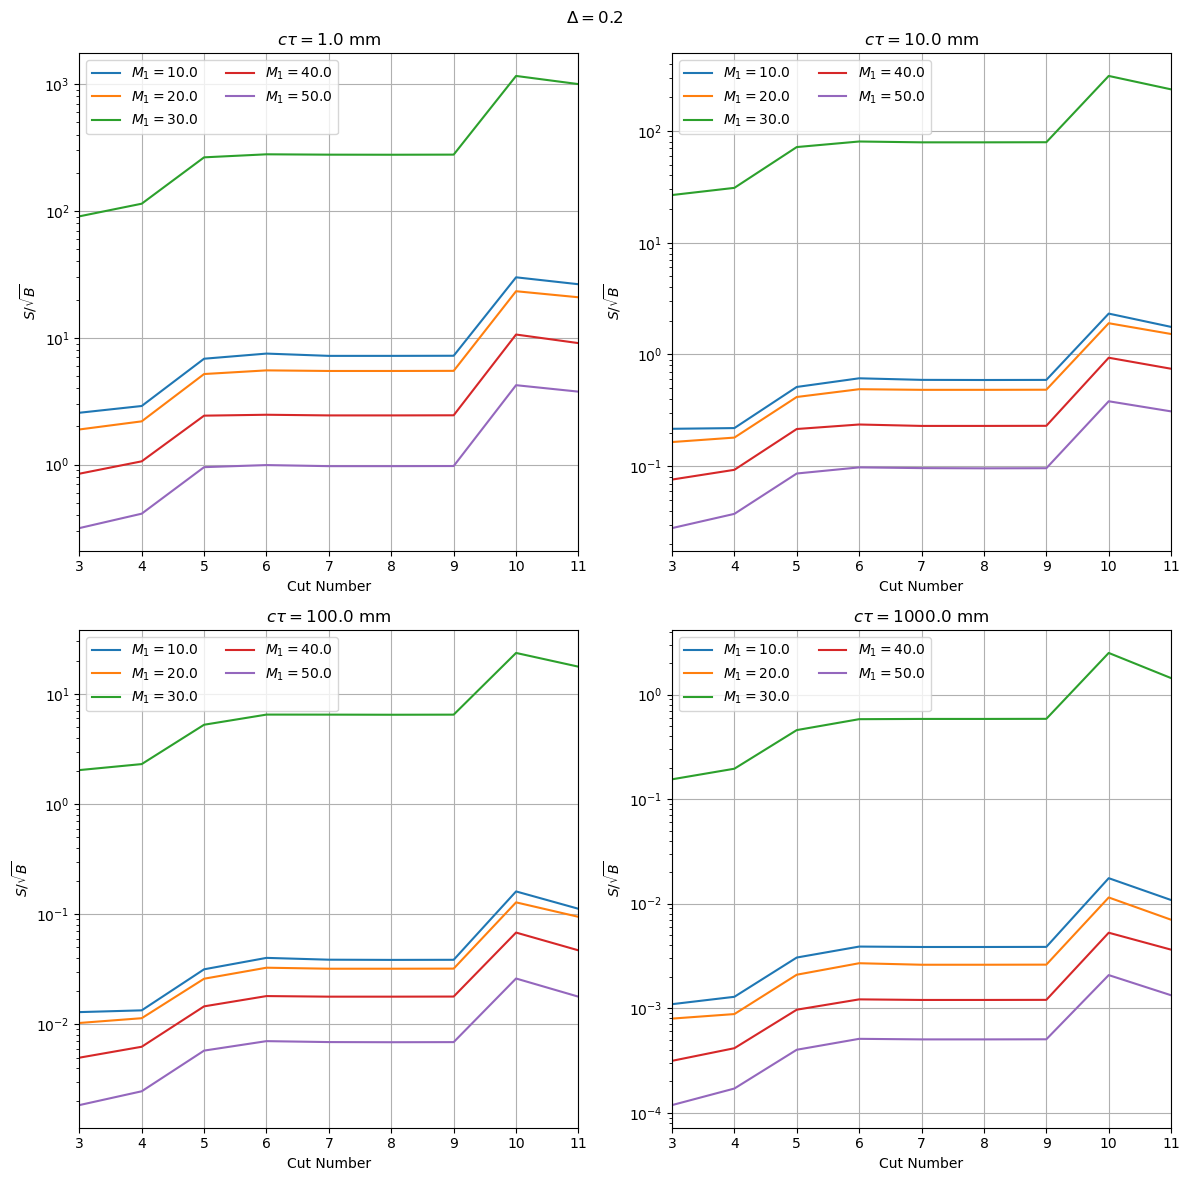

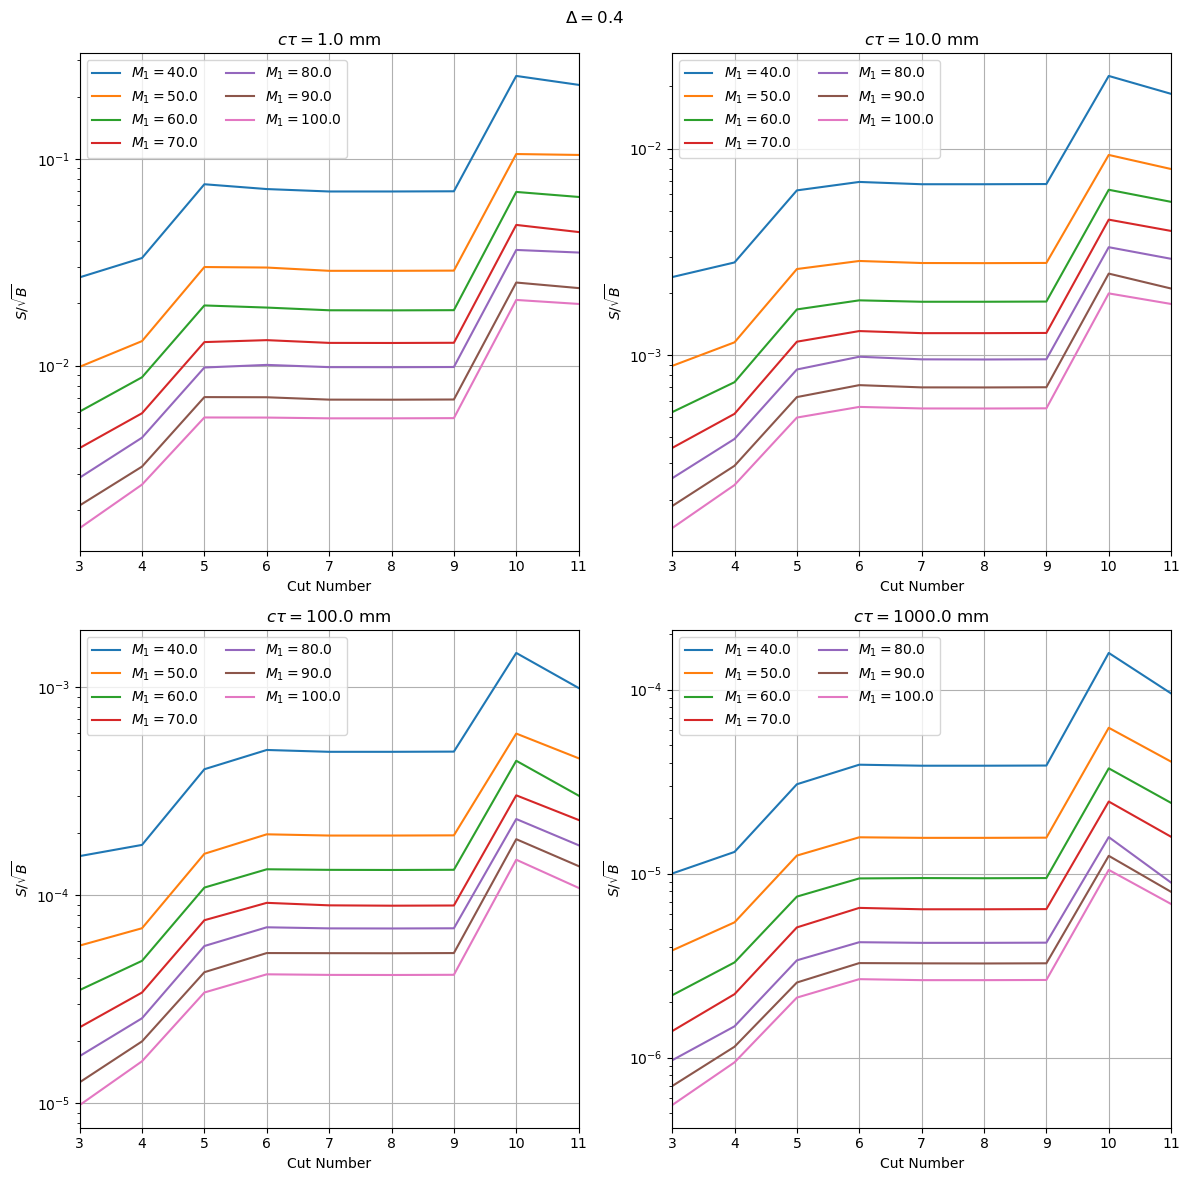

In [12]:
# S/sqrt(B), starting after MET trigger cut (cut3)
cut3above = [f"cut{n}" for n in np.arange(3,12)]
for delta in deltas:
    plt.figure(figsize=(12,12))
    m1s = sorted(list(set(si[si.delta==delta].m1)))
    for i,ct in enumerate(ctaus):
        plt.subplot(2,2,i+1)
        plt.title(r"$c\tau = {0}$ mm".format(ct))
        bkg_yields = [tot_cfc_q[cut] for cut in cut3above]
        for m1 in m1s:
            pt = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
            effs = [ct_s[pt][cut3above[i]]/np.sqrt(bkg_yields[i]) for i in range(len(cut3above))]
            plt.plot(np.arange(3,12),effs,label=r"$M_1 = {0}$".format(m1))
        plt.legend(loc='upper left',ncol=2)
        #plt.ylim([1e-5,1e2])
        plt.xlim([3,11])
        plt.yscale('log')
        plt.ylabel(r"$S/\sqrt{B}$")
        plt.xlabel("Cut Number")
        plt.grid()
    plt.suptitle(r"$\Delta = {0:.1f}$".format(delta))
    plt.tight_layout()
    plt.savefig(f"plots/cutflows/signal_signif_delta{delta:.1f}.pdf")
    #plt.close()